In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer, StandardScaler
# from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier, IsolationForest
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from scipy import stats
import pyhere


In [156]:
dir_data_raw = pyhere.here().resolve().joinpath("data", "raw")
dir_data_interim = pyhere.here().resolve().joinpath("data", "interim")
dir_data_external = pyhere.here().resolve().joinpath("data", "external")

In [157]:
csv_power_plants = pd.read_csv(dir_data_interim/"power_plants_with_generation_transformed.csv", index_col=[0])

In [158]:
# df_transformed = pd.read_csv(dir_data_external/"v2_transformed_data_combined_with_nasa.csv", index_col=['index'])
df_transformed = pd.read_csv(dir_data_external/"v3_transformed_data_combined_with_nasa.csv", index_col=['index'])

In [159]:
# csv_power_plants.loc[0:34935, ['capacity_mw', 'primary_fuel_transformed']].index.name = "index"
csv_power_plants.index.rename('index', inplace=True)

In [160]:
df_power_plants_raw = pd.read_csv(dir_data_raw/"global_power_plant_database.csv", usecols=['primary_fuel', 'other_fuel1', 'other_fuel2', 'other_fuel3'], engine='python')
csv_power_plants = csv_power_plants.join(df_power_plants_raw)

In [161]:

index_set_to_delete = csv_power_plants[csv_power_plants['other_fuel1'].isin(['Solar', 'Wind'])].index.tolist()
index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel2'].isin(['Solar', 'Wind'])].index.tolist())
index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel3'].isin(['Solar', 'Wind'])].index.tolist())

csv_power_plants.drop(index_set_to_delete, inplace = True)

# csv_power_plants.filter(like='other_fuel').columns

# csv_power_plants[csv_power_plants['other_fuel1'].isin(['Solar', 'Wind'])]
# csv_power_plants[csv_power_plants['other_fuel2'].isin(['Solar', 'Wind'])]
# csv_power_plants[csv_power_plants['other_fuel3'].isin(['Solar', 'Wind'])]

In [162]:
columns_to_combine = [
                        'capacity_mw',
                        'primary_fuel_transformed',
                        # 'other_fuel1',
                        # 'other_fuel2',
                        # 'other_fuel3',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        'generation_gwh_2019'
                    ]
# df_transformed_combined = df_transformed.merge(csv_power_plants.loc[0:24360, ['capacity_mw', 'primary_fuel_transformed']],left_on="index", right_on="index")
df_transformed_combined = df_transformed.merge(csv_power_plants[columns_to_combine],left_on="index", right_on="index")

primary_fuel_transformed
Other                       18859
Solar                       10664
Wind                         5340
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

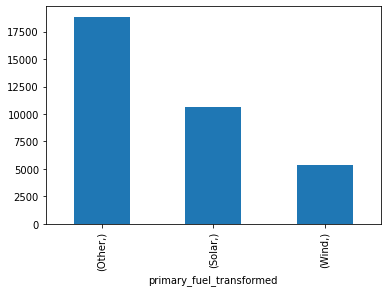

In [163]:
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [249]:
df_transformed_combined.describe()

,latitude,longitude,ANN_ALLSKY_SFC_LW_DWN_2012,ANN_ALLSKY_SFC_LW_DWN_2013,ANN_ALLSKY_SFC_LW_DWN_2014,ANN_ALLSKY_SFC_LW_DWN_2015,ANN_ALLSKY_SFC_LW_DWN_2016,ANN_ALLSKY_SFC_LW_DWN_2017,ANN_ALLSKY_SFC_LW_DWN_2018,ANN_ALLSKY_SFC_LW_DWN_2019,...,winter_WS50M_RANGE_AVG_2019,capacity_mw,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019,code_prim_fuel_transf
count,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,16063.000000,...,16063.000000,16063.000000,2510.000000,2823.000000,3235.000000,3687.000000,3915.000000,4092.000000,4231.000000,16063.000000
mean,34.421273,-5.593867,326.955380,327.522065,329.270143,330.158776,330.230377,329.669424,328.772178,327.446288,...,4.625573,115.205138,432.959023,488.296057,566.868057,506.991613,470.770139,380.083752,303.485152,0.998817
std,21.578976,76.593680,36.025361,35.804183,35.370569,35.887687,35.580202,35.344331,35.397378,36.595097,...,1.001356,389.796605,1740.086213,1879.081615,2102.594298,1984.809699,1906.050899,1642.354330,1352.905121,0.816153
min,-77.842800,-179.977700,197.210000,198.520000,198.210000,192.840000,190.880000,199.330000,198.380000,200.320000,...,1.473333,1.000000,-947.600000,-989.619000,-864.428000,-768.620000,-934.944000,-982.622000,-780.339000,0.000000
25%,32.211650,-76.179600,307.140000,307.400000,307.740000,308.720000,310.910000,309.720000,308.540000,306.040000,...,3.980000,5.000000,3.503500,3.295000,3.337500,3.319000,3.281500,2.984750,3.104000,0.000000
50%,40.767600,-2.159000,318.460000,320.550000,323.650000,321.450000,322.070000,322.750000,321.020000,318.590000,...,4.770000,15.000000,32.342500,29.496000,30.428000,24.765000,20.335000,14.259500,11.863000,1.000000
75%,47.484150,36.833900,342.850000,340.720000,342.570000,345.730000,343.660000,344.100000,344.655000,343.800000,...,5.271667,50.000000,234.079500,249.609000,269.421442,250.236000,228.977000,185.011890,155.249500,2.000000
max,71.010900,178.835900,431.160000,434.650000,432.660000,436.400000,433.580000,430.950000,428.620000,429.750000,...,8.076667,8535.000000,31431.080000,32320.917000,32525.595000,32377.477000,35116.000000,35136.000000,31920.368000,2.000000


In [217]:
# df_transformed_combined = df_transformed_combined.loc[df_transformed_combined['generation_gwh_2013'].notna() & df_transformed_combined['generation_gwh_2014'].notna() & df_transformed_combined['generation_gwh_2015'].notna() & df_transformed_combined['generation_gwh_2016'].notna() & df_transformed_combined['generation_gwh_2017'].notna() & df_transformed_combined['generation_gwh_2018'].notna() & df_transformed_combined['generation_gwh_2019'].notna()]

primary_fuel_transformed
Solar                       5364
Other                       5359
Wind                        5340
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

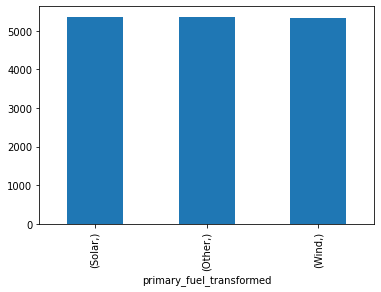

In [218]:
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [219]:
label_encoder = LabelEncoder()
# df_transformed_combined.isna().sum()
# df_transformed_combined[df_transformed_combined.isna().any(axis=1)]
# df_transformed_combined.dropna(inplace = True)
df_transformed_combined = df_transformed_combined[df_transformed_combined['primary_fuel_transformed'].notna()]
df_transformed_combined['code_prim_fuel_transf'] = label_encoder.fit_transform(df_transformed_combined['primary_fuel_transformed'])


In [220]:
df_target_equivalent = df_transformed_combined[['primary_fuel_transformed', 'code_prim_fuel_transf']].drop_duplicates()
df_target_equivalent

,primary_fuel_transformed,code_prim_fuel_transf
index,,
3,Other,0
18,Solar,1
91,Wind,2


## Balancing the data

In [221]:
# index_rows_to_delete_other = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 0].sample(4000).index
index_rows_to_delete_other = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 0].sample(13500).index
# index_rows_to_delete = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 0].sample(9000).index
# index_rows_to_delete_wind = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 2].sample(100).index
index_rows_to_delete_solar = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 1].sample(5300).index
# index_rows_to_delete_solar = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 1].sample(3000).index


ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
df_transformed_combined.drop(index_rows_to_delete_other, axis = 0, inplace = True)
df_transformed_combined.drop(index_rows_to_delete_solar, axis = 0, inplace = True)
# df_transformed_combined.drop(index_rows_to_delete_wind, axis = 0, inplace = True)

<AxesSubplot:xlabel='primary_fuel_transformed'>

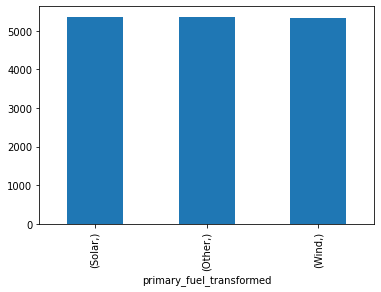

In [ ]:
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [222]:
df_transformed_combined.isna().sum()

latitude                          0
longitude                         0
ANN_ALLSKY_SFC_LW_DWN_2012        0
ANN_ALLSKY_SFC_LW_DWN_2013        0
ANN_ALLSKY_SFC_LW_DWN_2014        0
                              ...  
generation_gwh_2016           12376
generation_gwh_2017           12148
generation_gwh_2018           11971
generation_gwh_2019           11832
code_prim_fuel_transf             0
Length: 692, dtype: int64

In [223]:
# df_transformed_combined.isna().sum()
# df_transformed_combined[df_transformed_combined.isna().any(axis=1)]
# df_transformed_combined.dropna(inplace = True)
columns_to_drop = [
                        'capacity_mw',
                        'latitude',
                        'longitude',
                        'primary_fuel_transformed',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        'generation_gwh_2019'
                    ]
pre_X = df_transformed_combined.drop(columns=columns_to_drop)
pre_X.dropna(inplace = True)
X = pre_X.drop(columns=['code_prim_fuel_transf'])
y = pre_X['code_prim_fuel_transf']

In [224]:
y.value_counts()

1    5364
0    5359
2    5340
Name: code_prim_fuel_transf, dtype: int64

In [225]:
# sns.kdeplot(data=pre_X, x='winter_TQV_2009', hue='code_prim_fuel_transf', shade=True)

In [226]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [227]:
def get_accuracy(max_leaf_nodes, X_train, X_test, y_train, y_test):
    model = DecisionTreeClassifier(max_leaf_nodes = max_leaf_nodes, random_state=0)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds_val)

    return accuracy

In [228]:
def get_accuracy_knn(n_neighbors, X_train, X_test, y_train, y_test):
    model = KNeighborsClassifier(n_neighbors = n_neighbors)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds_val)

    return accuracy

In [229]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [230]:
def correlation_matrix(df: pd.DataFrame):
    """
    A function to calculate and plot
    correlation matrix of a DataFrame.
    """
    # Create the matrix
    matrix = df.corr()
    
    # Create cmap
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
    # Create a mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Make figsize bigger
    fig, ax = plt.subplots(figsize=(16,12))
    
    # Plot the matrix
    _ = sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, ax=ax)

In [180]:
# correlation_matrix(X.join(y))

In [181]:
# mi_scores = make_mi_scores(X, y)
# mi_scores[::3]

In [182]:
# plt.figure(dpi=100, figsize=(8, 30))
# plot_mi_scores(mi_scores)

In [183]:
# CLIMATE_FEATURES = {'ALLSKY_SFC_SW_DWN', 
#                     'CLRSKY_SFC_SW_DWN', 
#                     'ALLSKY_KT', 
#                     'WS10M_MIN_AVG', 
#                     'WS10M_MAX_AVG', 
#                     'WS50M_MAX_AVG', 
#                     'WS50M_MIN_AVG'} 
CLIMATE_FEATURES = {"ALLSKY_SFC_SW_DWN",
                        "CLRSKY_SFC_SW_DWN",
                        "ALLSKY_SFC_SW_DIFF",
                        "ALLSKY_SFC_SW_UP",
                        "ALLSKY_SFC_LW_DWN",
                        "ALLSKY_SFC_LW_UP",
                        "ALLSKY_SFC_SW_DNI",
                        # "ALLSKY_SFC_SW_DNI_MAX_RD",
                        "ALLSKY_SFC_SW_UP_MAX",
                        "CLRSKY_SFC_SW_DIFF",
                        "CLRSKY_SFC_SW_DNI",
                        "CLRSKY_SFC_SW_UP",
                        #"ALLSKY_KT",
                        "WS10M_MAX_AVG",
                        "WS50M_MAX_AVG",
                        "WS50M",
                        "WS50M_RANGE_AVG",
                        "WS10M",
                        "WS10M_RANGE_AVG"}   
SEASONS = {'autumn', 'spring', 'summer', 'winter'}
YEARS = {'2012', '2013', '2014', '2015', '2016', '2017', '2018'}

list_total = []
for feature in CLIMATE_FEATURES:
    feature_string = ""
    
    for season in SEASONS:
        dict_features_to_apply_mean = {}
        list_to_append = []
        for year in YEARS:
            feature_string = f"{season}_{feature}_{year}"
            
            list_to_append.append(feature_string)
        dict_features_to_apply_mean = {f"{season}_{feature}": list_to_append}
        # print("sasa")
        # print(dict_features_to_apply_mean)
    
        list_total.append(dict_features_to_apply_mean)
print(list_total)
# X[['autumn_ALLSKY_SFC_SW_DWN_2012', 'salary_3']].mean(axis=1)

[{'winter_WS10M': ['winter_WS10M_2018', 'winter_WS10M_2014', 'winter_WS10M_2013', 'winter_WS10M_2015', 'winter_WS10M_2012', 'winter_WS10M_2017', 'winter_WS10M_2016']}, {'spring_WS10M': ['spring_WS10M_2018', 'spring_WS10M_2014', 'spring_WS10M_2013', 'spring_WS10M_2015', 'spring_WS10M_2012', 'spring_WS10M_2017', 'spring_WS10M_2016']}, {'autumn_WS10M': ['autumn_WS10M_2018', 'autumn_WS10M_2014', 'autumn_WS10M_2013', 'autumn_WS10M_2015', 'autumn_WS10M_2012', 'autumn_WS10M_2017', 'autumn_WS10M_2016']}, {'summer_WS10M': ['summer_WS10M_2018', 'summer_WS10M_2014', 'summer_WS10M_2013', 'summer_WS10M_2015', 'summer_WS10M_2012', 'summer_WS10M_2017', 'summer_WS10M_2016']}, {'winter_WS50M_MAX_AVG': ['winter_WS50M_MAX_AVG_2018', 'winter_WS50M_MAX_AVG_2014', 'winter_WS50M_MAX_AVG_2013', 'winter_WS50M_MAX_AVG_2015', 'winter_WS50M_MAX_AVG_2012', 'winter_WS50M_MAX_AVG_2017', 'winter_WS50M_MAX_AVG_2016']}, {'spring_WS50M_MAX_AVG': ['spring_WS50M_MAX_AVG_2018', 'spring_WS50M_MAX_AVG_2014', 'spring_WS50M_MA

In [184]:
for dict_season_feature in list_total:
    for season_feature in dict_season_feature:
        print(dict_season_feature[season_feature])
        X[f'mean_{season_feature}']= X[dict_season_feature[season_feature]].mean(axis=1)
        X[f'std_{season_feature}']= X[dict_season_feature[season_feature]].std(axis=1)

['winter_WS10M_2018', 'winter_WS10M_2014', 'winter_WS10M_2013', 'winter_WS10M_2015', 'winter_WS10M_2012', 'winter_WS10M_2017', 'winter_WS10M_2016']
['spring_WS10M_2018', 'spring_WS10M_2014', 'spring_WS10M_2013', 'spring_WS10M_2015', 'spring_WS10M_2012', 'spring_WS10M_2017', 'spring_WS10M_2016']
['autumn_WS10M_2018', 'autumn_WS10M_2014', 'autumn_WS10M_2013', 'autumn_WS10M_2015', 'autumn_WS10M_2012', 'autumn_WS10M_2017', 'autumn_WS10M_2016']
['summer_WS10M_2018', 'summer_WS10M_2014', 'summer_WS10M_2013', 'summer_WS10M_2015', 'summer_WS10M_2012', 'summer_WS10M_2017', 'summer_WS10M_2016']
['winter_WS50M_MAX_AVG_2018', 'winter_WS50M_MAX_AVG_2014', 'winter_WS50M_MAX_AVG_2013', 'winter_WS50M_MAX_AVG_2015', 'winter_WS50M_MAX_AVG_2012', 'winter_WS50M_MAX_AVG_2017', 'winter_WS50M_MAX_AVG_2016']
['spring_WS50M_MAX_AVG_2018', 'spring_WS50M_MAX_AVG_2014', 'spring_WS50M_MAX_AVG_2013', 'spring_WS50M_MAX_AVG_2015', 'spring_WS50M_MAX_AVG_2012', 'spring_WS50M_MAX_AVG_2017', 'spring_WS50M_MAX_AVG_2016']


In [185]:
#  columns_delete = X.columns.str.contains('ALLSKY_KT') | X.columns.str.contains('ANN') | X.columns.str.contains('autumn_CLRSKY_SFC_SW_DWN_2019')
# columns_delete = X.columns.str.contains('ALLSKY_KT') | X.columns.str.contains('ANN') | X.columns.str.contains('2019') | X.columns.str.contains('2013') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('MIN')
# columns_delete = X.columns.str.contains('ALLSKY_KT') | X.columns.str.contains('2019') | X.columns.str.contains('2012') | X.columns.str.contains('2013') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') | X.columns.str.contains('MIN') | X.columns.str.contains('ANN')
# columns_delete = X.columns.str.contains('2019') | X.columns.str.contains('2013') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') | X.columns.str.contains('ANN') #| X.columns.str.contains('WS50M_RANGE_AVG') | X.columns.str.contains('WS10M_RANGE_AVG') | X.columns.str.contains('CLRSKY_SFC_SW_UP') | X.columns.str.contains('CLRSKY_SFC_SW_DNI') | X.columns.str.contains('CLRSKY_SFC_SW_DIFF') | X.columns.str.contains('ALLSKY_SFC_SW_UP_MAX') | X.columns.str.contains('ALLSKY_SFC_SW_DNI') | X.columns.str.contains('ALLSKY_SFC_LW_UP') | X.columns.str.contains('ALLSKY_SFC_LW_DWN') | X.columns.str.contains('ALLSKY_SFC_SW_UP') | X.columns.str.contains('ALLSKY_SFC_SW_DIFF')
columns_delete = X.columns.str.contains('2019') | X.columns.str.contains('2012') | X.columns.str.contains('2013') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018')
X = X.loc[:,~columns_delete]

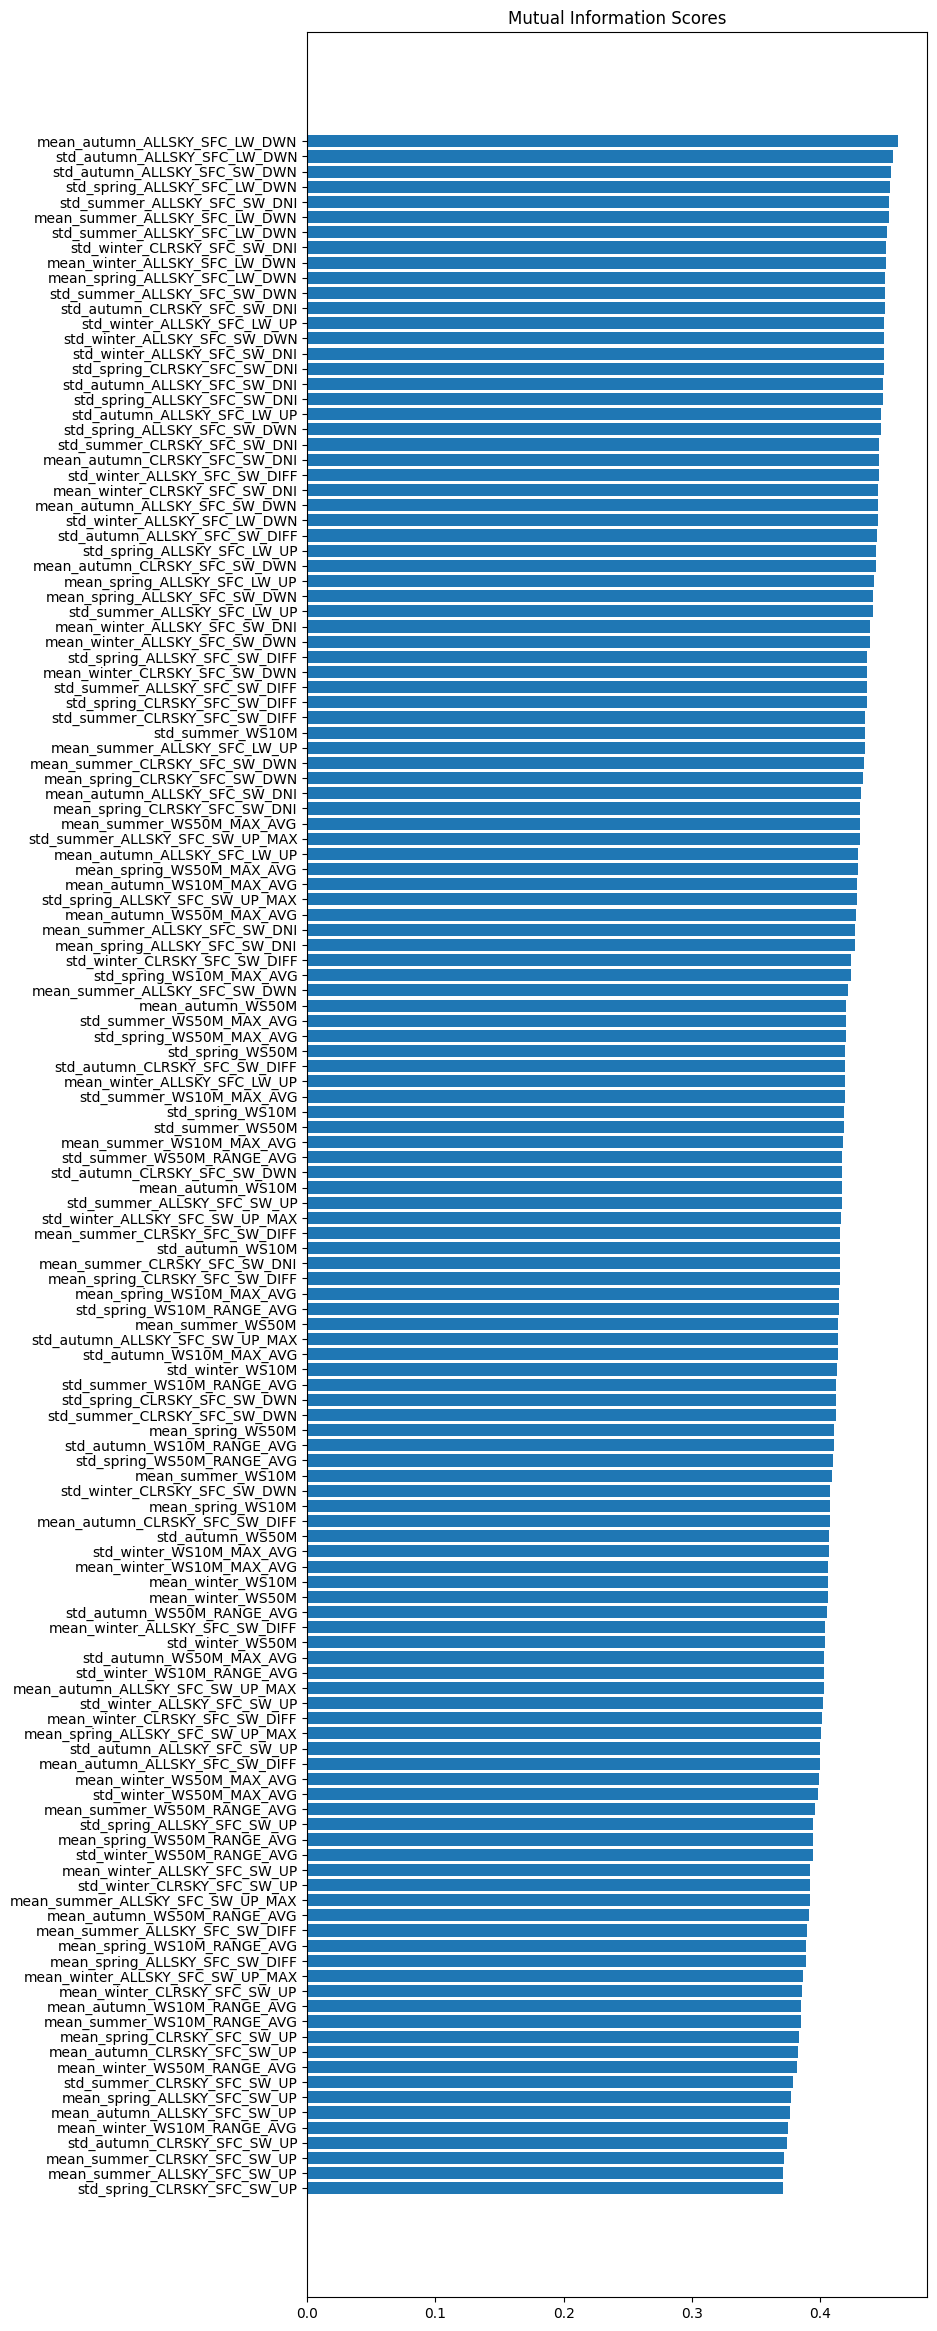

In [186]:
mi_scores = make_mi_scores(X, y)
plt.figure(dpi=100, figsize=(8, 30))
plot_mi_scores(mi_scores)

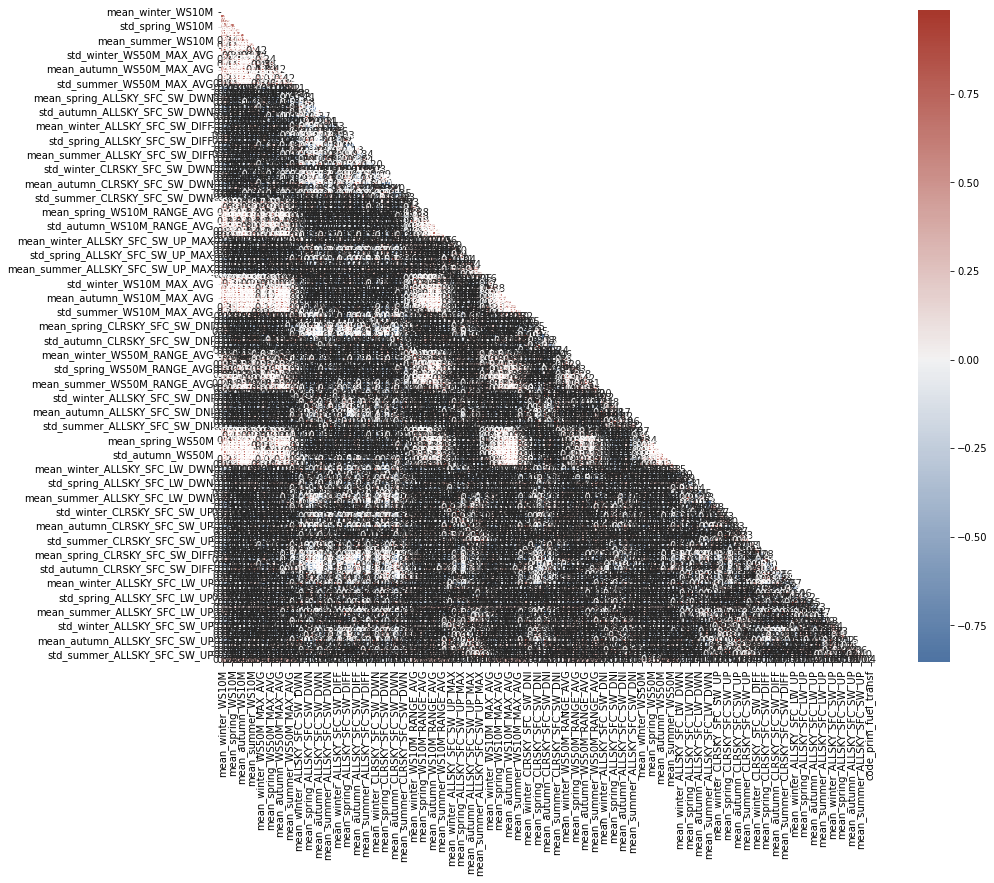

In [187]:
correlation_matrix(X.join(y))

In [133]:
X.columns

Index(['autumn_ALLSKY_SFC_LW_DWN_2012', 'autumn_ALLSKY_SFC_LW_UP_2012',
       'autumn_ALLSKY_SFC_SW_DIFF_2012', 'autumn_ALLSKY_SFC_SW_DNI_2012',
       'autumn_ALLSKY_SFC_SW_DWN_2012', 'autumn_ALLSKY_SFC_SW_UP_2012',
       'autumn_ALLSKY_SFC_SW_UP_MAX_2012', 'autumn_CLRSKY_SFC_SW_DIFF_2012',
       'autumn_CLRSKY_SFC_SW_DNI_2012', 'autumn_CLRSKY_SFC_SW_DWN_2012',
       'autumn_CLRSKY_SFC_SW_UP_2012', 'autumn_WS10M_2012',
       'autumn_WS10M_MAX_AVG_2012', 'autumn_WS10M_RANGE_AVG_2012',
       'autumn_WS50M_2012', 'autumn_WS50M_MAX_AVG_2012',
       'autumn_WS50M_RANGE_AVG_2012', 'spring_ALLSKY_SFC_LW_DWN_2012',
       'spring_ALLSKY_SFC_LW_UP_2012', 'spring_ALLSKY_SFC_SW_DIFF_2012',
       'spring_ALLSKY_SFC_SW_DNI_2012', 'spring_ALLSKY_SFC_SW_DWN_2012',
       'spring_ALLSKY_SFC_SW_UP_2012', 'spring_ALLSKY_SFC_SW_UP_MAX_2012',
       'spring_CLRSKY_SFC_SW_DIFF_2012', 'spring_CLRSKY_SFC_SW_DNI_2012',
       'spring_CLRSKY_SFC_SW_DWN_2012', 'spring_CLRSKY_SFC_SW_UP_2012',
       'sp

In [231]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2,random_state = 0)

In [232]:
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(train_X)

/home/tomas/renewable_power_plants/renewable_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [248]:
# select all rows that are not outliers
mask = yhat == -1
train_X[mask]

,ANN_ALLSKY_SFC_LW_DWN_2012,ANN_ALLSKY_SFC_LW_DWN_2013,ANN_ALLSKY_SFC_LW_DWN_2014,ANN_ALLSKY_SFC_LW_DWN_2015,ANN_ALLSKY_SFC_LW_DWN_2016,ANN_ALLSKY_SFC_LW_DWN_2017,ANN_ALLSKY_SFC_LW_DWN_2018,ANN_ALLSKY_SFC_LW_DWN_2019,ANN_ALLSKY_SFC_LW_UP_2012,ANN_ALLSKY_SFC_LW_UP_2013,...,winter_WS50M_MAX_AVG_2018,winter_WS50M_MAX_AVG_2019,winter_WS50M_RANGE_AVG_2012,winter_WS50M_RANGE_AVG_2013,winter_WS50M_RANGE_AVG_2014,winter_WS50M_RANGE_AVG_2015,winter_WS50M_RANGE_AVG_2016,winter_WS50M_RANGE_AVG_2017,winter_WS50M_RANGE_AVG_2018,winter_WS50M_RANGE_AVG_2019
index,,,,,,,,,,,,,,,,,,,,,
17968,300.87,303.90,304.58,305.34,304.18,303.42,302.94,302.12,8.26,8.32,...,7.800000,8.830000,4.500000,3.710000,3.813333,4.636667,3.886667,4.176667,3.706667,4.470000
23072,316.74,324.81,327.20,323.70,324.41,326.45,319.37,321.34,8.72,8.72,...,10.930000,11.273333,5.290000,5.380000,5.510000,5.626667,6.286667,5.643333,6.216667,6.313333
2150,410.64,414.73,413.73,412.38,414.13,412.98,410.88,412.55,11.09,11.05,...,10.853333,10.783333,2.346667,2.273333,2.100000,1.913333,2.096667,2.676667,2.076667,2.200000
22949,322.80,328.51,331.05,326.28,330.36,330.91,324.76,325.98,8.85,8.83,...,9.650000,9.896667,4.926667,4.673333,4.456667,4.840000,5.526667,5.180000,5.113333,5.143333
17013,342.99,339.73,340.30,342.83,340.91,337.82,344.66,336.15,10.35,10.29,...,6.813333,7.606667,5.346667,5.883333,5.620000,5.526667,5.303333,5.883333,5.290000,5.576667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5043,332.04,332.15,329.85,335.30,334.45,327.96,324.91,322.66,9.55,9.50,...,10.610000,10.196667,4.653333,4.660000,4.876667,4.793333,4.456667,4.736667,5.013333,4.300000
5405,263.75,263.68,265.59,266.27,267.61,278.48,278.09,279.46,8.38,8.52,...,8.770000,8.303333,6.070000,7.116667,7.100000,7.360000,6.263333,6.603333,6.796667,6.356667
1901,409.70,413.61,412.33,411.38,412.91,412.43,410.92,412.02,11.13,11.18,...,12.110000,11.946667,4.623333,4.110000,4.056667,4.056667,5.000000,4.736667,4.410000,4.146667


## DECISION TREE CLASSIFIER

1500


<AxesSubplot:>

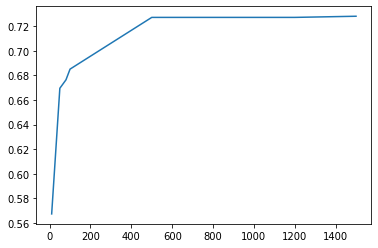

In [189]:
candidate_max_leaf_nodes = [10, 50, 80, 100, 500, 1200, 1500]
results = {}
# Write loop to find the ideal tree size from candidate_max_leaf_nodes


results = {node: get_accuracy(node, train_X, val_X, train_y, val_y) for node in candidate_max_leaf_nodes}
# results = {node: get_accuracy(node, train_X_scaled_pca, val_X_scaled_pca, train_y, val_y) for node in candidate_max_leaf_nodes}
# for node in candidate_max_leaf_nodes:
#     results[node] = get_accuracy(node, X_train, X_test, y_train, y_test)
# Store the best value of max_leaf_nodes (it will be either 5, 25, 50, 100, 250 or 500)
best_tree_size = max(results, key=results.get)
print(best_tree_size)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [190]:
tree_model = DecisionTreeClassifier(max_leaf_nodes = best_tree_size, random_state=0)
tree_model.fit(train_X, train_y)

DecisionTreeClassifier(max_leaf_nodes=1500, random_state=0)

0.7279800809212574
[0.72455649 0.73295985 0.73015873 0.72820672 0.73287671]
Mean: 0.7297517014277691, Standard Deviation: 0.0031496275638259593


<AxesSubplot:>

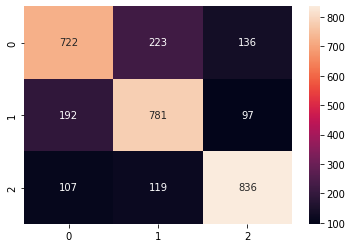

In [191]:
y_pred = tree_model.predict(val_X)
print(tree_model.score(val_X, val_y))
results_cvs = cross_val_score(tree_model, X, y, cv=StratifiedKFold(shuffle = True))
print(results_cvs)
print(f'Mean: {results_cvs.mean()}, Standard Deviation: {results_cvs.std()}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# RANDOM FOREST CLASSIFIER

In [34]:
# Numbers of trees
n_estimators = [int(x) for x in np.arange(10, 101, 10)]
# Numbers of features to consider at every split
# max_features = [1, "sqrt", "log2"]
# Maximum numbers of levels in tree
max_depth = [50, 100, 500]
# Minimum numbers of samples required to split a node
min_samples_split = [2, 10, 50, ]
# Minimum numbers of samples required at each leaf node
min_samples_leaf = [1, 10, 50, 100]
# Method of selecting samples for training each tree
bootstrap = [True, False]

max_leaf_nodes = [10, 100, 500]

param_grid = {
                'n_estimators': n_estimators,
                # 'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap,
                'max_leaf_nodes': max_leaf_nodes
            }



In [35]:
rf_model = RandomForestClassifier(random_state=0)
# rf_grid = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv=5, verbose = 2, n_jobs=4)
rf_grid = RandomizedSearchCV(estimator = rf_model, param_distributions = param_grid, n_iter = 10, cv=5, verbose = 2, n_jobs=4)

In [ ]:
# rf_grid.fit(train_X_scaled_pca, train_y)
rf_grid.fit(train_X, train_y)

In [37]:
rf_grid.best_params_

{'n_estimators': 30,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 500,
 'max_depth': 500,
 'bootstrap': False}

In [38]:
rf_grid.score(val_X, val_y)
# rf_grid.score(val_X_scaled_pca, val_y)

0.7563025210084033

In [192]:
rf_model2 = RandomForestClassifier(bootstrap= False,
 max_depth= 50,
 min_samples_leaf= 1,
 min_samples_split= 50,
 n_estimators= 60,
 max_leaf_nodes= 500,
 random_state=0)
rf_model2.fit(train_X, train_y)
y_pred = rf_model2.predict(val_X)
# print(cross_val_score(tree_model, X, y, cv=5))

0.7597261126672892
[0.75879241 0.7718643  0.77217554 0.77926526 0.75840598]
Mean: 0.7681006953770854, Standard Deviation: 0.008198149397762148


<AxesSubplot:>

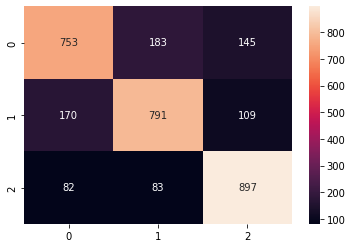

In [193]:

print(rf_model2.score(val_X, val_y))
results_cvs = cross_val_score(rf_model2, X, y, cv=StratifiedKFold(shuffle = True))
print(results_cvs)
print(f'Mean: {results_cvs.mean()}, Standard Deviation: {results_cvs.std()}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

In [35]:
accuracy_score(val_y, y_pred)

0.7619047619047619

In [43]:
rf_model2.score(val_X, val_y)

0.7039337474120083

2    1101
1    1058
0    1054
Name: code_prim_fuel_transf, dtype: int64


<AxesSubplot:>

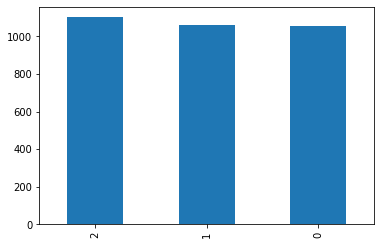

In [62]:
print(val_y.value_counts())
val_y.value_counts().plot.bar()

# XGBOOST

In [194]:
xgbclass_model_1 = XGBClassifier(random_state=0)
xgbclass_model_1.fit(train_X, train_y)
# xgbclass_model_1.fit(train_X_scaled_pca, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

0.761
[0.768 0.761 0.768 0.772 0.758]
Mean: 0.766, Standard Deviation: 0.005


<AxesSubplot:>

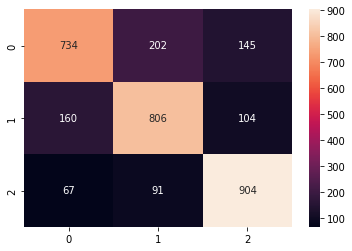

In [195]:
y_pred = xgbclass_model_1.predict(val_X)
print(np.around(xgbclass_model_1.score(val_X, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(xgbclass_model_1, X, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

In [49]:
param_grid = {
                'n_estimators': [5,10,50,100,500,1000],
                'learning_rate': [0.01,0.05,0.1,0.2],
                'max_depth': [2,3,4],
            }

In [50]:
xgb_grid = GridSearchCV(estimator = XGBClassifier(), param_grid = param_grid, cv=5, verbose = 2, n_jobs=4)

In [ ]:
xgb_grid.fit(train_X, train_y)

In [36]:
xgb_grid.best_params_

{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50}

In [37]:
xgb_grid.score(val_X, val_y)

0.7432712215320911

In [65]:
xgbclass_model_2 = XGBClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=4)
# xgbclass_model_2 = XGBClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=4, early_stopping_rounds=5)
xgbclass_model_2.fit(train_X, train_y, 
             eval_set=[(val_X, val_y)], 
             verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=4, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [ ]:
y_pred = xgbclass_model_2.predict(val_X)
print(np.around(xgbclass_model_2.score(val_X, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(xgbclass_model_2, X, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# KNN

3


<AxesSubplot:>

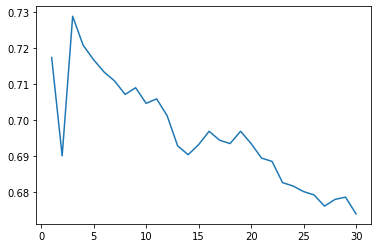

In [197]:
candidate_n_neighbors = np.arange(1,31)
results = {}
# Write loop to find the ideal tree size from candidate_max_leaf_nodes


# results = {n: get_accuracy_knn(n, train_X_scaled_pca, val_X_scaled_pca, train_y, val_y) for n in candidate_n_neighbors}
results = {n: get_accuracy_knn(n, train_X, val_X, train_y, val_y) for n in candidate_n_neighbors}
best_n_neighbors = max(results, key=results.get)
print(best_n_neighbors)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [198]:
knn_model_1 = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn_model_1.fit(train_X, train_y)

KNeighborsClassifier(n_neighbors=3)

0.729
[0.72  0.704 0.726 0.737 0.726]
Mean: 0.723, Standard Deviation: 0.011


<AxesSubplot:>

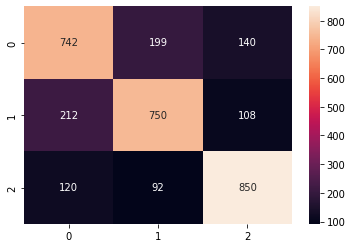

In [199]:
y_pred = knn_model_1.predict(val_X)
print(np.around(knn_model_1.score(val_X, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(knn_model_1, X, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

In [200]:
# train_X_normalized = stats.boxcox(train_X)
x = train_X.values #returns a numpy array
min_max_scaler = MinMaxScaler()
power_transformer = PowerTransformer(method='yeo-johnson')
standard_scaler = StandardScaler()
# x_scaled = min_max_scaler.fit_transform(x)
x_scaled = power_transformer.fit_transform(x)
# x_scaled = standard_scaler.fit_transform(x)
train_X_scaled = pd.DataFrame(x_scaled, index=train_X.index, columns=train_X.columns)

x = val_X.values #returns a numpy array
# x_scaled = min_max_scaler.fit_transform(x)
x_scaled = power_transformer.fit_transform(x)
# x_scaled = standard_scaler.fit_transform(x)
val_X_scaled = pd.DataFrame(x_scaled, index=val_X.index, columns=val_X.columns)

x = X.values #returns a numpy array
# x_scaled = min_max_scaler.fit_transform(x)
x_scaled = power_transformer.fit_transform(x)
# x_scaled = standard_scaler.fit_transform(x)
X_scaled = pd.DataFrame(x_scaled, index=X.index, columns=X.columns)


In [201]:
train_X_scaled

,mean_winter_WS10M,std_winter_WS10M,mean_spring_WS10M,std_spring_WS10M,mean_autumn_WS10M,std_autumn_WS10M,mean_summer_WS10M,std_summer_WS10M,mean_winter_WS50M_MAX_AVG,std_winter_WS50M_MAX_AVG,...,mean_summer_ALLSKY_SFC_LW_UP,std_summer_ALLSKY_SFC_LW_UP,mean_winter_ALLSKY_SFC_SW_UP,std_winter_ALLSKY_SFC_SW_UP,mean_spring_ALLSKY_SFC_SW_UP,std_spring_ALLSKY_SFC_SW_UP,mean_autumn_ALLSKY_SFC_SW_UP,std_autumn_ALLSKY_SFC_SW_UP,mean_summer_ALLSKY_SFC_SW_UP,std_summer_ALLSKY_SFC_SW_UP
index,,,,,,,,,,,,,,,,,,,,,
16339,1.645138,1.454924,0.582475,0.718004,1.135421,0.539481,0.295383,0.496249,1.745644,1.737173,...,1.356271,0.171656,-1.477769,-1.131182,0.069579,0.312666,-1.269202,-1.398755,-0.142952,-1.172726
24886,-1.533391,-1.441166,-1.143929,-1.616978,-1.242354,-1.548215,-0.571576,-0.686697,-1.290534,-1.665262,...,-1.369296,1.454185,0.190267,-0.708147,-1.034083,-0.527255,0.284468,0.408539,-0.354936,1.224929
24932,-1.892223,-1.717208,-1.254215,-1.076063,-1.463510,-1.288835,-0.532001,-1.663374,-1.607143,-1.683328,...,-1.329130,1.625286,0.435490,0.282537,-0.945896,-0.417484,0.585229,-0.205566,-0.384599,1.566396
10949,0.997924,1.730900,0.118950,0.854994,0.726302,1.224567,-0.162371,0.101367,1.236989,1.836158,...,0.274725,0.477115,-1.175990,-1.046424,1.053949,1.514220,-1.247667,-1.172199,0.736438,1.005435
12751,0.469952,1.204903,-0.405797,-0.933904,-0.008732,0.420421,-0.654361,-0.113990,0.714720,1.265990,...,0.272979,0.496570,-0.744557,1.326242,0.682034,1.150604,-1.328515,-0.565153,0.327782,0.057347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28208,0.562388,0.019500,1.022768,0.494792,1.124368,0.289023,1.187865,0.148329,0.822409,0.096880,...,-1.323981,1.077396,0.997536,1.117344,0.065291,-0.222575,1.278670,0.089042,0.914531,0.865639
7345,0.634207,-0.133566,0.788225,0.932921,0.421014,0.019585,-0.122911,-0.599903,1.042124,-0.195569,...,0.799984,-0.544852,0.520596,1.010928,1.343009,1.740031,-0.101589,0.508287,0.778769,-0.289360
21533,-1.755168,-0.530739,-1.963260,-1.273532,-2.021730,-0.983126,-2.104252,-1.664992,-1.794877,0.127373,...,0.954367,-1.812259,-0.116233,-0.367310,0.599550,0.030972,0.025287,-0.377677,0.411514,-0.677245


In [202]:
def axis_calculation(total_columns_df, grid_columns):
    rows = int(total_columns_df / grid_columns)
    if( total_columns_df % grid_columns) > 0:
        rows += 1

    return (rows, grid_columns)
print(axis_calculation(30, 4))

(8, 4)


In [146]:

# # plt.figure(figsize=(200,200))
# grid_columns = 5
# result_axis = axis_calculation(len(train_X_scaled.columns), grid_columns)
# fig, axs = plt.subplots(result_axis[0],result_axis[1], figsize=(30,20))
# fig.subplots_adjust(hspace=.5)

# aux_cont = 0
# aux_cont_2 = 0
# # fig.figsize=(30,30)
# for col in train_X_scaled.columns:
# # #     # print(col)
#     sns.kdeplot(data=train_X_scaled, x=col, shade=True, ax=axs[aux_cont_2, aux_cont] )
#     # axs[aux_cont_2, aux_cont].set_xlabel('Participation Rate')
#     # axs[aux_cont_2, aux_cont].set_ylabel('Frequency')
#     # axs[aux_cont_2, aux_cont].set_title("sasa")
#     axs[aux_cont_2, aux_cont].set_xticklabels([])
#     aux_cont += 1
#     if aux_cont >= grid_columns:
#         aux_cont_2 +=1
#         aux_cont = 0

In [ ]:
# train_X_scaled.hist(bins=100, xlabelsize=8, ylabelsize=10, figsize=(30,20))


In [ ]:
# WITHOUT SCALING OR NORMALIZING
# train_X.hist(bins=100, xlabelsize=8, ylabelsize=10, figsize=(30,20))

3


<AxesSubplot:>

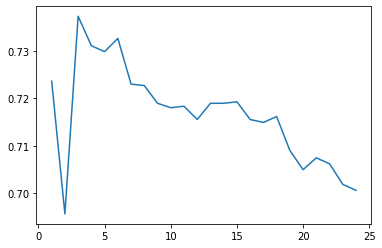

In [203]:
candidate_n_neighbors = np.arange(1,25)
results = {}
# Write loop to find the ideal tree size from candidate_max_leaf_nodes


results = {n: get_accuracy_knn(n, train_X_scaled, val_X_scaled, train_y, val_y) for n in candidate_n_neighbors}
best_n_neighbors = max(results, key=results.get)
print(best_n_neighbors)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [204]:
knn_model_2 = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn_model_2.fit(train_X_scaled, train_y)

KNeighborsClassifier(n_neighbors=3)

In [205]:
knn_model_2.score(val_X_scaled, val_y)

0.737317149081855

0.737
[0.729 0.745 0.739 0.727 0.721]
Mean: 0.732, Standard Deviation: 0.009


<AxesSubplot:>

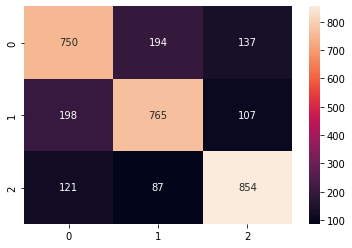

In [206]:
y_pred = knn_model_2.predict(val_X_scaled)
print(np.around(knn_model_2.score(val_X_scaled, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(knn_model_2, X_scaled, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# NAIVE BAYES

0.54
[0.558 0.536 0.545 0.551 0.546]
Mean: 0.547, Standard Deviation: 0.007


<AxesSubplot:>

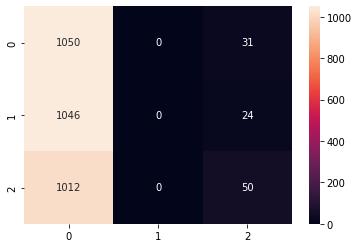

In [207]:
nb_model_1 = GaussianNB()

#Entreno el modelo
nb_model_1.fit(train_X, train_y)

#Realizo una predicción
y_pred = nb_model_1.predict(val_X_scaled)
print(np.around(nb_model_1.score(val_X, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(nb_model_1, X, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

0.535
[0.557 0.541 0.554 0.571 0.537]
Mean: 0.552, Standard Deviation: 0.012


<AxesSubplot:>

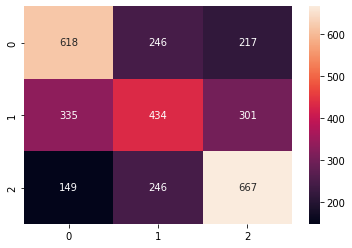

In [208]:
nb_model_2 = GaussianNB()
nb_model_2.fit(train_X_scaled, train_y)


y_pred = nb_model_2.predict(val_X_scaled)
print(np.around(nb_model_2.score(val_X_scaled, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(nb_model_2, X_scaled, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# SVM

In [209]:
svm_model_1 = SVC(random_state=22)
svm_model_1.fit(train_X_scaled, train_y)

SVC(random_state=22)

In [210]:
y_pred = svm_model_1.predict(val_X_scaled)
print(np.around(svm_model_1.score(val_X_scaled, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(svm_model_1, X_scaled, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

0.728


KeyboardInterrupt: 

In [87]:
param_grid = {
                'C': [0.5, 1, 10, 100], # NOTE: values for C must be > 0
                'gamma': ['scale', 1, .1, .01, .001, .0001],
                'kernel': ['rbf'] # Some linear fittings last to 7/8 mins. Not recommended at all
            }
# svm_grid = GridSearchCV(estimator = SVC(), param_grid = param_grid, cv=5, verbose = 2, n_jobs=4)
svm_grid = RandomizedSearchCV(estimator = SVC(), param_distributions = param_grid, cv=5, verbose = 2, n_jobs=4)

In [ ]:
svm_grid.fit(train_X_scaled, train_y)

In [89]:
svm_grid.best_params_

{'kernel': 'rbf', 'gamma': 1, 'C': 100}

In [90]:
svm_model_2 = SVC(C= 100, gamma= 1, kernel='rbf', random_state=22)
svm_model_2.fit(train_X_scaled, train_y)

SVC(C=100, gamma=1, random_state=22)

In [91]:
y_pred = svm_model_2.predict(val_X_scaled)

In [92]:
svm_model_2.score(val_X_scaled, val_y)

0.7556935817805382

<AxesSubplot:>

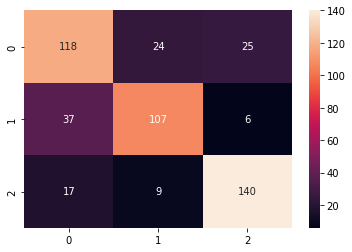

In [93]:
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# PCA

In [165]:
pca = PCA(n_components=3)
pca.fit(train_X_scaled)

PCA(n_components=3)

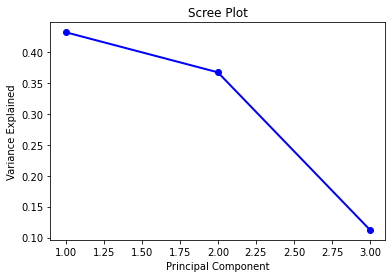

In [166]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [163]:
train_X_scaled_pca = pca.transform(train_X_scaled)
val_X_scaled_pca = pca.transform(val_X_scaled)

In [164]:
train_pc1_coords = train_X_scaled_pca[:,0]
train_pc2_coords = train_X_scaled_pca[:,1]
train_pc3_coords = train_X_scaled_pca[:,2]

# LOGISTIC REGRESSION

/home/tomas/renewable_power_plants/renewable_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6659105638366818


<AxesSubplot:>

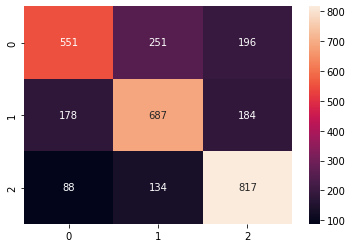

In [166]:
logistic_model_1 = LogisticRegression(random_state=22)
logistic_model_1.fit(train_X_scaled, train_y)
y_pred = logistic_model_1.predict(val_X_scaled)
print(logistic_model_1.score(val_X_scaled, val_y))
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# LDA

In [71]:
lda = LDA(n_components = 2)
train_X_scaled_lda = lda.fit_transform(train_X_scaled, train_y)
val_X_scaled_lda = lda.transform(val_X_scaled)

0.6342981637099284


<AxesSubplot:>

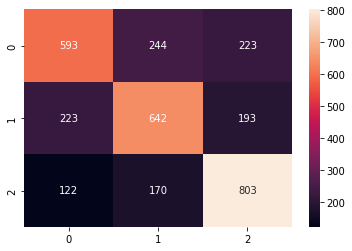

In [72]:
lda.fit(train_X_scaled_lda, train_y)
y_pred = lda.predict(val_X_scaled_lda)
print(lda.score(val_X_scaled_lda, val_y))
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# NEURAL NETWORK

0.4572051042639278


<AxesSubplot:>

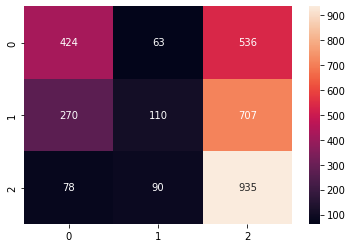

In [151]:
nn_model_1 = MLPClassifier(hidden_layer_sizes=(25,50,25), max_iter=200,activation = 'tanh',solver='adam',random_state=1)
nn_model_1.fit(train_X, train_y)
y_pred = nn_model_1.predict(val_X)
print(nn_model_1.score(val_X, val_y))
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# TEST PREDICTION

In [56]:
df_to_predict = pd.read_csv(dir_data_external/"data_predict.csv", index_col=['index'])
df_to_predict.drop(columns=['latitude','longitude'], inplace=True)

In [57]:
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None

In [58]:
# print(df_to_predict.columns)
# print(df_to_predict.columns.tolist())

In [59]:
# columns_delete = df_to_predict.columns.str.contains('ALLSKY_KT') | df_to_predict.columns.str.contains('ANN') | df_to_predict.columns.str.contains('autumn_CLRSKY_SFC_SW_DWN_2019')
columns_delete = df_to_predict.columns.str.contains('ALLSKY_KT') | df_to_predict.columns.str.contains('ANN') | df_to_predict.columns.str.contains('2019') | df_to_predict.columns.str.contains('2013') | df_to_predict.columns.str.contains('2014') | df_to_predict.columns.str.contains('2015') | df_to_predict.columns.str.contains('2016') | df_to_predict.columns.str.contains('2017') | df_to_predict.columns.str.contains('MIN')
df_to_predict = df_to_predict.loc[:,~columns_delete]
# df_to_predict = df_to_predict.loc[:,~COLUMNS_TO_DELETE]

In [60]:
y_predicted_test = xgbclass_model_1.predict(df_to_predict)
print(y_predicted_test)

[1]


In [85]:
df_target_equivalent

,primary_fuel_transformed,code_prim_fuel_transf
index,,
24713,Solar,1
24717,Other,0
24749,Wind,2


# BAGGING CLASSIFIER

In [152]:
bag_model_1 = BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=50)
bag_model_1.fit(train_X_scaled, train_y)
y_pred = bag_model_1.predict(val_X_scaled)
# print(bag_model_1.score(val_X_scaled, val_y))

# results_cvs = cross_val_score(bag_model_1, train_X_scaled, train_y, cv=5)
# print(results_cvs)
# print(f'Mean: {results_cvs.mean()}, Standard Deviation: {results_cvs.std()}')
# confusion_matrix_return = confusion_matrix(val_y, y_pred)
# sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')


print(np.around(bag_model_1.score(val_X_scaled, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(bag_model_1, X_scaled, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

0.735


KeyboardInterrupt: 

In [153]:
classifier = {
        'KNeighbors': KNeighborsClassifier(n_neighbors=9),
        'DecisionTree': DecisionTreeClassifier(max_leaf_nodes=50),
        'XGBClassifier': XGBClassifier()
    }

for name, estimator in classifier.items():
    bag_class = BaggingClassifier(base_estimator=estimator, n_estimators=5).fit(train_X_scaled, train_y)
    
    bag_pred = bag_class.predict(val_X_scaled)

    print(f'Accuracy Bagging with {name}: {accuracy_score(bag_pred, val_y)}')
    print('')
    print(f'Mean: {cross_val_score(bag_class, X, y, cv=5).mean()}, Standard Deviation: {cross_val_score(tree_model, X, y, cv=5).std()}')
    print('')

Accuracy Bagging with KNeighbors: 0.7158418923124805

Mean: 0.4892685536924054, Standard Deviation: 0.05696883952623632

Accuracy Bagging with DecisionTree: 0.6554621848739496

Mean: 0.5259357125996933, Standard Deviation: 0.05696883952623632

Accuracy Bagging with XGBClassifier: 0.7366946778711485

Mean: 0.5372651343642479, Standard Deviation: 0.05696883952623632



# VOTING CLASSIFIER

In [211]:


votclass_model_1 = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier(n_neighbors=9)), ('dt', DecisionTreeClassifier(max_leaf_nodes=50)), ('xgb', XGBClassifier())], voting='hard')
votclass_model_1.fit(train_X_scaled, train_y)

y_pred = votclass_model_1.predict(val_X_scaled)

print(np.around(votclass_model_1.score(val_X_scaled, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(votclass_model_1, X_scaled, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

0.735


KeyboardInterrupt: 

# ADABOOST

0.633
[0.657 0.647 0.662 0.648 0.653]
Mean: 0.654, Standard Deviation: 0.006


<AxesSubplot:>

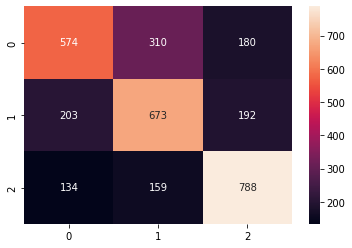

In [269]:
adaBoost_model_1 = AdaBoostClassifier(n_estimators=100)
adaBoost_model_1.fit(train_X_scaled, train_y)

y_pred = adaBoost_model_1.predict(val_X_scaled)

print(np.around(adaBoost_model_1.score(val_X_scaled, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(adaBoost_model_1, X_scaled, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# GRADIENT TREE BOOSTING

In [168]:
gradboost_model_1 = GradientBoostingClassifier(n_estimators=40)
gradboost_model_1.fit(train_X, train_y)
y_pred = gradboost_model_1.predict(val_X)
print(np.around(gradboost_model_1.score(val_X, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(gradboost_model_1, X, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

0.648


KeyboardInterrupt: 